# Generating GeoMAD composites

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Individual remote sensing images can be affected by noisy data, including clouds, cloud shadows, and haze. 
To produce cleaner images that can be compared more easily across time, we can create 'summary' images or 'composites' that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. 

One approach is to create a [geomedian](https://github.com/daleroberts/hdmedians). A `geomedian` is based on a high-dimensional statistic called the 'geometric median' [(Small 1990)](https://www.jstor.org/stable/1403809), which effectively trades a temporal stack of poor quality observations for a single high-quality pixel composite with reduced spatial noise [(Roberts et al. 2017)](https://ieeexplore.ieee.org/abstract/document/8004469). In contrast to a standard median, a geomedian maintains the relationship between spectral bands.  This allows us to conduct further analysis on the composite images just as we would on the original satellite images (e.g by allowing the calculation of common band indices, like NDVI).

DE Africa's GEoMAD product (**Geo**median and **M**edian **A**bsolute **D**eviations), in addition to containing geomedians of the surface relfectance bands, GeoMAD also includes three Median Absolute Deviation (MAD) layers. These are higher-order statistical measurements on variation relative to the geomedian. These layers can be used on their own or together with geomedian to gain insights about the land surface and understand its change over time.

All the data of the selected timeframe has to be loaded to compute a composite, so geomedians can be computationally intensive to calculate, especially over large areas or long timescales. To assist with such analyses, DE Africa hosts a number of pre-calculated geoMAD products:

* [Sentinel-2 annual GeoMAD](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html) from 2017 to present, with product name `gm_s2_annual`
* [Sentinel-2 semi-annual (six-month) GeoMAD](https://explorer.digitalearth.africa/products/gm_s2_semiannual/extents) from 2019 to present, with product name `gm_s2_semiannual`
* [Landat annual GeoMAD](https://explorer.digitalearth.africa/products/gm_ls8_annual/extents) from 2013 to present, with product name `gm_ls8_annual`


This reduces the time and resource needed to calculate the geomedian if you are conducting analysis over an annual timescale. Instructions on how to use the geomedian from the Sentinel-2 GeoMAD can be found in the [Datasets/GeoMAD.ipynb](../Datasets/GeoMAD.ipynb) notebook.

For analysis on other timescales, such as investigating change over seasons, it is not possible to use the annual geomedian product. In those cases, it can be useful to calculate GeoMAD for that specific time period.

## Description
In this notebook we will take of time series of noisy satellite images and calculate a GeoMAD composite which is largely free of clouds and other noisy data.

GeoMAD computations are expensive in terms of memory, data bandwidth, and CPU usage. The ODC has a useful function, [geomedian_with_mads](https://github.com/opendatacube/odc-tools/blob/6c7a8bf9058d4e96ca27e5de21c7ff039338fc1c/libs/algo/odc/algo/_geomedian.py#L305) that allows [dask](https://docs.dask.org/en/latest/) to perform the computation in parallel across many threads to speed things up. In this notebook a `local dask cluster` is used, but the same approach should work using a larger, distributed dask cluster.

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import numpy as np
import matplotlib.pyplot as plt
from odc.algo import geomedian_with_mads
from deafrica_tools.plotting import rgb
from deafrica_tools.datahandling import load_ard
from deafrica_tools.dask import create_local_dask_cluster

import geopandas as gpd


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Set up a dask cluster

This will help keep our memory use down and conduct the analysis in parallel. If you'd like to view the `dask dashboard`, click on the hyperlink that prints below the cell. You can use the dashboard to monitor the progress of calculations.


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:41969 Dashboard: /user/timon.weitkamp@hotmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Generating_geomedian_composites')

## Load Sentinel-2 from the datacube

Here we are loading in a timeseries of cloud-masked Sentinel-2 satellite images through the datacube API using the [load_ard](../Frequently_used_code/Using_load_ard.ipynb) function. 
This will provide us with some data to work with. To limit computation and memory this example uses only three optical bands (red, green, blue).

In [4]:
# Set up centre of area of interest, and area to buffer coordinates by
vector_file = '../data/buffered.geojson' #contains the study area coordinates
gdf = gpd.read_file(vector_file)

area = "Xai-Xai"
gdf_area = gdf[(gdf['area'] == area)]
gdf_area

lat = gdf_area.lat 
lon = gdf_area.lon
buffer_lon = 0.18 #buffer
buffer_lat = 0.18

#below are the calculations of the various composite lenghts

# 1 x 12 months
#date = ('2019-10','2020-09'); file_name = area + "_mo12_20192020"

# 2 x 6 months
#date = ('2019-10','2020-03'); file_name = area + "_6mo_2019Q4_2020Q1"
#date = ('2020-04','2020-09'); file_name = area + "_6mo_2020Q2_2020Q3"

date = ('2021-10','2022-03'); file_name = area + "_6mo_2021Q4_2022Q1"
#date = ('2022-04','2022-09'); file_name = area + "_6mo_2022Q2_2022Q3"

# 4 x 3 months
#date = ('2021-10','2021-12'); file_name = area + "_3mo_2021_Q4"
#date = ('2022-01','2022-03'); file_name = area + "_3mo_2022_Q1"
#date = ('2022-04','2022-06'); file_name = area + "_3mo_2022_Q2"
#date = ('2022-06','2022-09'); file_name = area + "_3mo_2022_Q3"

#date = ('2019-10','2019-12'); file_name = area + "_3mo_2019_Q4"
#date = ('2020-01','2020-03'); file_name = area + "_3mo_2020_Q1"
#date = ('2020-04','2020-06'); file_name = area + "_3mo_2020_Q2"
#date = ('2020-06','2020-09'); file_name = area + "_3mo_2020_Q3"

# 6 x 2 months
#date = ('2019-10','2019-11'); file_name = area + "_2mo_2019_10_11"
#date = ('2019-12','2020-01'); file_name = area + "_2mo_2020_12_01"
#date = ('2020-02','2020-03'); file_name = area + "_2mo_2020_02_03"
#date = ('2020-04','2020-05'); file_name = area + "_2mo_2020_04_05"
#date = ('2020-06','2020-07'); file_name = area + "_2mo_2020_06_07"
#date = ('2020-08','2020-09'); file_name = area + "_2mo_2020_08_09"

# Create a reusable query
query = {
    'x': (lon-buffer_lon, lon+buffer_lon),
    'y': (lat+buffer_lat, lat-buffer_lat),
    'time': date,
    'measurements': ['red',
                     'green',
                     'blue',
                     'nir',
                     'swir_1',
                     'swir_2',
                    'red_edge_1',
                    'red_edge_2'],
    'resolution': (-10, 10),
    'group_by': 'solar_day',
    'output_crs': 'EPSG:6933'
}

Compared to the typical use of `load_ard` which by default returns data with floating point numbers containing `NaN` (i.e. `float32`), in this example we will set the `dtype` to `'native'`. 
This will keep our data in its original integer data type (i.e. `Int16`), with nodata values marked with `-999`.
Doing this will halve the amount of memory our data takes up, which can be extremely valuable when conducting large-scale analyses.

In [5]:
# Load available data
ds = load_ard(dc=dc, 
              products=['s2_l2a'],
              dask_chunks={'x':5000, 'y':5000},
              mask_filters=(['opening',5], ['dilation',5]), #improve cloud mask
              dtype='native',
              min_gooddata=.3, #can be changed to include more or less images/quality into the composite
              **query)

# Print output data
print(ds)

/home/jovyan/.local/lib/python3.8/site-packages/deafrica_tools/datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 53 out of 72 time steps with at least 30.0% good quality pixels
Applying morphological filters to pq mask (['opening', 5], ['dilation', 5])
Applying pixel quality/cloud mask
Returning 53 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 53, y: 4189, x: 3475)
Coordinates:
  * time         (time) datetime64[ns] 2021-10-02T07:56:49 ... 2022-03-31T07:...
  * y            (y) float64 -3.016e+06 -3.016e+06 ... -3.058e+06 -3.058e+06
  * x            (x) float64 3.167e+06 3.167e+06 ... 3.201e+06 3.201e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 4189, 3475), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 4189, 3475), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 4189, 3475), meta=np.ndarray>
    nir          (time, 

## Plot timesteps in true colour

To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a series of timesteps. 
Black areas indicate where clouds or other invalid pixels in the image have been set to `-999` to indicate no data.

The code below will plot three timesteps of the time series we just loaded.


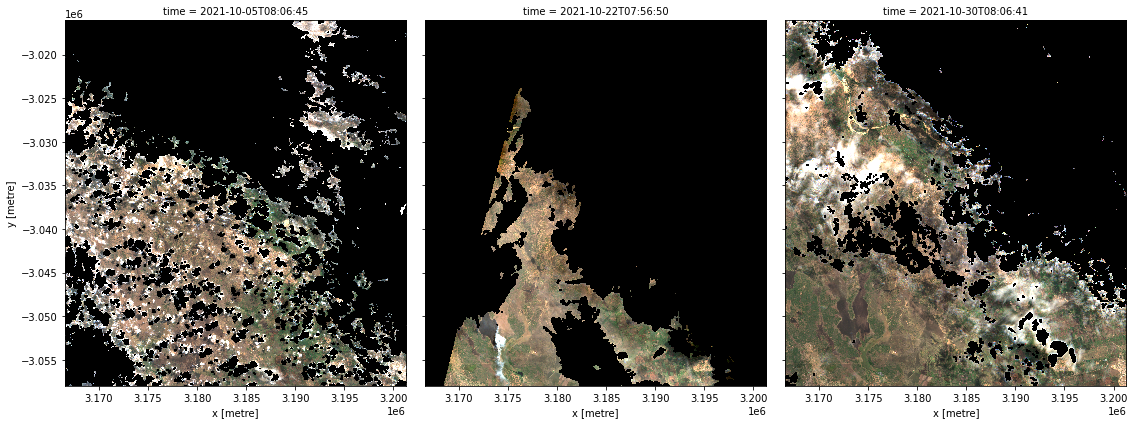

In [15]:
# Set the timesteps to visualise
timesteps = [1, 5, 7]

# Generate RGB plots at each timestep
rgb(ds, index=timesteps)


## Generate median absolute deviations

In addition to running a geomedian composite, which will return the median observations for each band, we can also compute the variation that each pixel undergoes during the time series. The `geomedian_with_mads` function returns three measures of variability: the spectral median absolute deviation (`smad`), the Euclidian median absolute deviation (`emad`), and the bray-curtis median absolute deviation (`bcmad`).

To compute the three measures of variability simply pass `compute_mads=True` to the `geomedian_with_mads` function. This function also supports returning the `count`, which returns the number of clear observations for each pixel.

In [7]:
%%time

geomads = geomedian_with_mads(ds,
                              compute_mads=True,
                              compute_count=True)

geomads = geomads.compute()
print(geomads)

<xarray.Dataset>
Dimensions:     (y: 4189, x: 3475)
Coordinates:
  * y           (y) float64 -3.016e+06 -3.016e+06 ... -3.058e+06 -3.058e+06
  * x           (x) float64 3.167e+06 3.167e+06 ... 3.201e+06 3.201e+06
Data variables:
    red         (y, x) uint16 842 871 941 1075 1126 ... 1184 1320 1222 1201 1368
    green       (y, x) uint16 849 845 877 945 962 ... 965 1066 1025 1056 1208
    blue        (y, x) uint16 613 609 634 704 741 707 ... 771 850 768 776 900
    nir         (y, x) uint16 2476 2471 2500 2435 2245 ... 2683 2916 3107 3118
    swir_1      (y, x) uint16 2435 2446 2533 2530 2554 ... 3574 3540 3538 3545
    swir_2      (y, x) uint16 1617 1629 1781 1785 1904 ... 3128 3062 3087 3098
    red_edge_1  (y, x) uint16 1385 1389 1471 1464 1428 ... 1681 1749 1808 1810
    red_edge_2  (y, x) uint16 2197 2173 2144 2136 1974 ... 2330 2424 2529 2524
    smad        (y, x) float32 0.02688 0.02965 0.03141 ... 0.002402 0.002059
    emad        (y, x) float32 1.167e+03 1.241e+03 1.306e+03 .

### Plot median absolute deviations and clear count

In [8]:
#fig,ax=plt.subplots(1,4, sharey=True, figsize=(20,5))
#geomads['smad'].plot(ax=ax[0], cmap='plasma', robust=True)
#geomads['emad'].plot(ax=ax[1], cmap='magma', robust=True)
#geomads['bcmad'].plot(ax=ax[2], cmap='cividis', robust=True)
#geomads['count'].plot(ax=ax[3], cmap='viridis', robust=True)
#ax[0].set_title('SMAD')
#ax[1].set_title('EMAD')
#ax[2].set_title('BCMAD')
#ax[3].set_title('Clear Count');

## Add VI

In [9]:
from deafrica_tools.bandindices import calculate_indices

geomads = calculate_indices(geomads, index=['NDVI','BSI','NDWI'], satellite_mission='s2')


In [10]:
geomads

<xarray.Dataset>
Dimensions:     (y: 4189, x: 3475)
Coordinates:
  * y           (y) float64 -3.016e+06 -3.016e+06 ... -3.058e+06 -3.058e+06
  * x           (x) float64 3.167e+06 3.167e+06 ... 3.201e+06 3.201e+06
Data variables: (12/15)
    red         (y, x) uint16 842 871 941 1075 1126 ... 1184 1320 1222 1201 1368
    green       (y, x) uint16 849 845 877 945 962 ... 965 1066 1025 1056 1208
    blue        (y, x) uint16 613 609 634 704 741 707 ... 771 850 768 776 900
    nir         (y, x) uint16 2476 2471 2500 2435 2245 ... 2683 2916 3107 3118
    swir_1      (y, x) uint16 2435 2446 2533 2530 2554 ... 3574 3540 3538 3545
    swir_2      (y, x) uint16 1617 1629 1781 1785 1904 ... 3128 3062 3087 3098
    ...          ...
    emad        (y, x) float32 1.167e+03 1.241e+03 1.306e+03 ... 761.5 749.1
    bcmad       (y, x) float32 0.1087 0.1147 0.1097 ... 0.05232 0.05018 0.04757
    count       (y, x) uint16 16 16 16 16 16 16 16 16 ... 30 31 31 31 31 32 32
    NDVI        (y, x) float64 0.4925 0.4788 0.4531 ... 0.4094 0.4424 0.3901
    BSI         (y, x) float64 0.02953 0.03705 0.05145 ... 0.1276 0.09928 0.1002
    NDWI        (y, x) float64 -0.4893 -0.4903 -0.4806 ... -0.4927 -0.4415
Attributes:
    units:         1
    nodata:        0
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

# Save raster

In [11]:
from datacube.utils.cog import write_cog

write_cog(geomads.to_array(),
          fname= "MAD/S2/"+file_name+".tif", #"MAD/Nabusenga2019sMADQ3.tif",
          overwrite=True)

PosixPath('MAD/S2/Chokwe_6mo_2021Q4_2022Q1.tif')

In [12]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 2

t = np.linspace(1, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [13]:
print(datacube.__version__)

1.8.7


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-09-22'